## **Transcription speech to text (+ traduction)**

<br>

> #### &emsp; &emsp; Ce notebook contient :
>
> &emsp; Un bref rappel du contexte (utilité de l'application déployée)
>
> 1. La présentation et l'exploration du testing set
>
> 2. Notre baseline : <br> le modèle wav2vec2 pour la trancription <br>
>    (+ nllb-200-distilled-600M pour la traduction)
>
> 3. La nouvelle méthode : modèle whisper <br>
>
> 4. La comparaison des résultats des modèles text to speech, <br>
>    en évaluant (WER) la qualité des transcripts proposés par les 2 modèles <br>
>
> 5. Une évaluation plus subjective de la qualité des traductions obtenues <br>
>
> &emsp; En conclusion, une synthèse récapitulative (tableau), baseline vs nouvelle méthode <br><br>


## 0. Contexte, Imports


In [1]:
# Les cas d'utilisation possibles d'un traducteur automatique sont très variés.
# Cet outil (de pure science-fiction il y a encore quelques années !)
# peut aider bien sûr lors d'un voyage par exemple, ou dans le cadre professionnel.
# Il permet à deux personnes ne parlant la même langue de communiquer très facilement.

# L'application déployée dans ce projet a été développée pour une situation bien précise :
# Il s'agit de répondre aux besoin d'un restaurant situé dans une zone touristique...
# et se préparant de plus à l'approche des jeux olympiques.
# Cela nous donne des objectifs précis.

# Voici les points soulignés par la cliente, gérante du restaurant :

# détection auto
# Imaginons qu'un client se présente, mais personne ne le comprend.
# Pire, personne ne parvient à identifier avec certitude la langue qu'il parle.
# C'est la première chose que notre modèle doit être capable de faire,
# détecter automatiquement la langue.

# bruit
# L'environnement d'un restaurant n'est pas du tout idéal, car il y a généralement un fonds sonore.
# Le modèle devra donc autant que possible être robuste à un certain niveau de bruit.

# rapidité
# Le service d'un restaurant comporte souvent des "rushs" où il est essentiel pour l'équipe
# d'être très efficace, pour apporter les repas aussi vite que possible.
# Le modèle déployé doit donc être suffisant rapide, ici cela a réelle importance.
# Impossible d'attendre une taduction pendant une minute.
# Il faut avoir une réponse de qualité, en quelques secondes.

# confidentialité / sécurité
# La gérante souhaite être certaine que la confidentialité des clients est assurée.
# Pour cette raison, plutôt que d'utiliser une API, nous allons importer les modèles.
# L'appli est déployée sur le cloud avec streamlit, mais le restaurant utilise une version
# totalement locale, où rien n'est uploadé.
# On peut vérifier dans le code (app_rosetta.py) que l'enregistrement audio n'est jamais
# sauvegardé, il s'agit d'un fichier temporaire.
# Cela nous amène au dernier point :

# hors-connexion
# Le restaurant souhaite que l'outil fonctionne hors connexion, en cas de coupure du réseau
# ou éventuelle coupure électrique (très rare, mais peut se produire)
# Ils utiliseront donc la version locale, qui a servi au déployement,
# et qui fonctionne sans problème, connexion ou pas.

# facilité d'utilisation


### 0.1 Librairies, réglages


In [2]:
# paths, folders/files
import os, sys, random
from glob import glob
import re
import time

# test : un module (openCV) est difficile à trouver ds les répos conda standards.
# On veut l'installer ds l'env local, pas dans la base (de préférence, pas très grave au pire.)
# -> Check if CONDA_DEFAULT_ENV is set
if 'CONDA_DEFAULT_ENV' in os.environ:
    current_env = os.environ['CONDA_DEFAULT_ENV']
    print(f"Current conda environment: {current_env}")
else: # OK never reached, le notebook charge forcement un env dans le kernel avant d'executer la 1ere cell
    print("No conda environment is activated.")
    %conda activate env_p6 # nom de l'environnement local


# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
# from collections import Counter


# Visualisation
from pprint import pprint
import matplotlib as matplot
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import seaborn as sns
import plotly.express as px
# from PIL import Image, ImageOps #, ImageEnhance

%pip install soundfile sounddevice

import soundfile as sf
import sounddevice as sd


# Feature engineering
from sklearn import preprocessing

try:
    import librosa
except:
    print('Installing librosa...')
    %pip install librosa
    print('done')
    import librosa

import IPython.display as ipd
import librosa.display
from scipy.io import wavfile as wav

try:
    from pydub import AudioSegment
    from pydub.playback import play
except:
    print('Installing pydub...')
    %pip install --upgrade pydub
    print('done')
    from pydub import AudioSegment
    from pydub.playback import play

try:
    import torch
except:
    print('Installing pytorch...')
    %pip install --upgrade torch
    print('done')
    import torch

import transformers
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

try:
    from tqdm.auto import tqdm
except:
    %pip install tqdm
    from tqdm.auto import tqdm

%env TOKENIZERS_PARALLELISM=true
device = torch.device('cuda')

try:
    import whisper
except:
    print('Installing whisper...')
    %pip install git+https://github.com/openai/whisper.git
    print('done')
    import whisper

import pickle


print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('librosa version ' + librosa.__version__)
print('plt version ' + matplot.__version__) # 3.7 pour compatibilité avec librosa.display.waveshow
print('transformers ' + transformers.__version__) # > 4.3 ? ok

# plt.style.use('ggplot')
pd.set_option('display.max_rows', 200)


# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=7)


Current conda environment: myenv_p7


Note: you may need to restart the kernel to use updated packages.
env: TOKENIZERS_PARALLELISM=true

Python version 3.11.8 (main, Feb 26 2024, 21:39:34) [GCC 11.2.0]
pandas version 2.2.1
librosa version 0.10.1
plt version 3.7.2
transformers 4.37.2

Number of CPU cores: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 fonctions


In [3]:
# dataframes


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))

In [4]:
# graphs EDA


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, color='#7cf', ax=ax, rwidth=0.9)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, color='#7cf', showfliers=False, medianprops=medianprops,
                      patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def doughnut(df, feature, title, width=6, height=6):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(2)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()



[(0.851, 0.871, 0.784, 1.0), (0.627, 0.78, 0.784, 1.0)]


### 0.3 Variables globales


In [5]:
size_test = 30 # max 2426
model_type = 'small' # tiny, base, small, medium, large


In [6]:
# test

languages = [ # 98 total but these have wer accuracy > 50% which is an industry standard benchmark
    'Afrikaans', 'Arabic', 'Armenian', 'Azerbaijani', 'Belarusian', 'Bosnian', 'Bulgarian', 'Catalan', 'Chinese',
    'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Finnish', 'French', 'Galician', 'German', 'Greek',
    'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Kannada', 'Kazakh', 'Korean',
    'Latvian', 'Lithuanian', 'Macedonian', 'Malay', 'Marathi', 'Maori', 'Nepali', 'Norwegian', 'Persian', 'Polish',
    'Portuguese', 'Romanian', 'Russian', 'Serbian', 'Slovak', 'Slovenian', 'Spanish', 'Swahili', 'Swedish', 'Tagalog',
    'Tamil', 'Thai', 'Turkish', 'Ukrainian', 'Urdu', 'Vietnamese', 'Welsh'
]
len(languages)


57

## 1 Exploration et préparation des données


### 1.1 Infos générales sur le dataset


In [7]:
raw_data = pd.read_csv(f'./data/mls_french_opus/metainfo.txt', sep='|')

quick_look(raw_data)


shape : (4960, 7)


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


,SPEAKER,GENDER,PARTITION,MINUTES,BOOK ID,TITLE,CHAPTER
4955,9834,M,test,6.681,9697,Zadig ou la destinée,Chapitre VII. Les disputes et les audiences
4956,9834,M,test,7.779,9697,Zadig ou la destinée,Chapitre IV. L'envieux
4957,9834,M,test,7.573,9697,Zadig ou la destinée,Chapitre I. Le borgne
4958,9834,M,test,2.995,9697,Zadig ou la destinée,Chapitre II. Le nez
4959,9834,M,test,3.237,9697,Zadig ou la destinée,Chapitre V. Les généreux


uniques :


 SPEAKER                            178
  GENDER                              2
PARTITION                             3
 MINUTES                           4530
 BOOK ID                            160
            TITLE                   160
           CHAPTER                 4620
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
SPEAKER,SPEAKER,0,4960,0.0,int64
GENDER,GENDER,0,4960,0.0,object
PARTITION,PARTITION,0,4960,0.0,object
MINUTES,MINUTES,0,4960,0.0,float64
BOOK ID,BOOK ID,0,4960,0.0,int64
TITLE,TITLE,0,4960,0.0,object
CHAPTER,CHAPTER,0,4960,0.0,object


In [8]:
# On veut partition test uniquement

# data = raw_data.loc[raw_data['PARTITION'] == 'test', :].copy()

# 'PARTITION' n'existe pas ??


In [9]:
# Print the names of all columns
print(raw_data.columns)

# OK...


Index(['  SPEAKER   ', '   GENDER   ', ' PARTITION  ', '  MINUTES   ',
       '  BOOK ID   ', '             TITLE              ',
       '            CHAPTER            '],
      dtype='object')


In [10]:
raw_data.columns = [col.lower().strip() for col in raw_data.columns]

print(raw_data.columns)


Index(['speaker', 'gender', 'partition', 'minutes', 'book id', 'title',
       'chapter'],
      dtype='object')


In [11]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

print(data.shape)
data.head()

# J'imagine que c'est le mm problème.


(0, 7)


,speaker,gender,partition,minutes,book id,title,chapter


In [12]:
print(raw_data['speaker'][0])
display(raw_data.loc[raw_data['speaker'] == 10065].head())

# ça fonctionne pour le lecteur / la lectrice


10065


,speaker,gender,partition,minutes,book id,title,chapter
0,10065,M,train,9.002,10039,Saint Évangile selon Saint Marc,Chapitre 09
1,10065,M,train,9.845,10039,Saint Évangile selon Saint Marc,Chapitre 06
2,10065,M,train,6.503,10039,Saint Évangile selon Saint Marc,Chapitre 15
3,10065,M,train,6.788,10039,Saint Évangile selon Saint Marc,Chapitre 05
4,10065,M,train,5.059,10039,Saint Évangile selon Saint Marc,Chapitre 02


In [13]:
print(raw_data['partition'][0])
print(raw_data['partition'][4959])

raw_data['partition'] = raw_data['partition'].apply(
    lambda x: x.strip())

print(raw_data['partition'][0])
print(raw_data['partition'][4959])

# ok


   train    
    test    
train
test


### 1.2 test partition


In [14]:
data = raw_data.loc[raw_data['partition'] == 'test', :].copy()

print(data.shape)
data.head()


(95, 7)


,speaker,gender,partition,minutes,book id,title,chapter
4865,1406,M,test,6.995,1028,"Mille et une nuits, tome 1",010 - Dixième nuit
4866,1406,M,test,4.992,1028,"Mille et une nuits, tome 1",009 - Neuvième nuit
4867,1406,M,test,3.554,1028,"Mille et une nuits, tome 1",008 - Huitième nuit. Histoire du pêcheur
4868,1406,M,test,1.734,1417,À se tordre,Le pendu bienveillant
4869,1406,M,test,7.491,1417,À se tordre,Esthetic


### 1.3 Transcripts


In [15]:
transcripts = pd.read_csv(f'./data/mls_french_opus/test/transcripts.txt', sep='\t', header=None)

quick_look(transcripts)

# uniques ? 0 doublon ? checker
# en fait c exactement ce qu'il nous faut pour eval modele
# just turn 0 into path
# and add model prediction


shape : (2426, 2)


,0,1
0,1406_1028_000000,pendant le second siècle je fis serment d'ouvr...
1,1406_1028_000001,non ta mort est certaine dit le génie choisis ...
2,1406_1028_000002,la nuit suivante appela sa soeur quand il en f...
3,1406_1028_000003,à l'aspect d'un monstre d'une grandeur si déme...
4,1406_1028_000004,le sultan qui n'avait pas moins d'envie que di...


,0,1
2421,9834_9697_000156,par les plus grands forfaits sur le trône affe...
2422,9834_9697_000157,il parla avec tant de grâce d'esprit et de rai...
2423,9834_9697_000158,quand tu manges donne à manger aux chiens duss...
2424,9834_9697_000159,d'autres traces en un sens différent qui parai...
2425,9834_9697_000160,à ce vain bruit de paroles qu'on appelait conv...


uniques :


0    2426
1    2425
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
0,0,0,2426,0.0,object
1,1,0,2426,0.0,object


### 1.4 Test sample


In [16]:
# encore bcp trop long (1 prediction peut prendre 1 min avec le modèle large)

test_data = transcripts.sample(n=size_test, random_state=42)
test_data.reset_index(inplace=True)

quick_look(test_data)


shape : (1, 3)


,index,0,1
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...


,index,0,1
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...


uniques :


index    1
0        1
1        1
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
index,index,0,1,0.0,int64
0,0,0,1,0.0,object
1,1,0,1,0.0,object


### 1.5 Adresses


In [17]:
def id_into_path(file_name):
    # Split the file name into parts
    parts = file_name.split('_')

    # Create the path using the parts
    path = f'./data/mls_french_opus/test/audio/{parts[0]}/{parts[1]}/{file_name}.opus'

    return path


test_data['path'] = test_data[0].apply(id_into_path)

test_data.head()


,index,0,1,path
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...


### 1.6 Clean true transcript


In [18]:
test_data[1] = test_data[1].apply(
    lambda x: x.strip())

test_data.head()

# ?


,index,0,1,path
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...


### 1.7 EDA


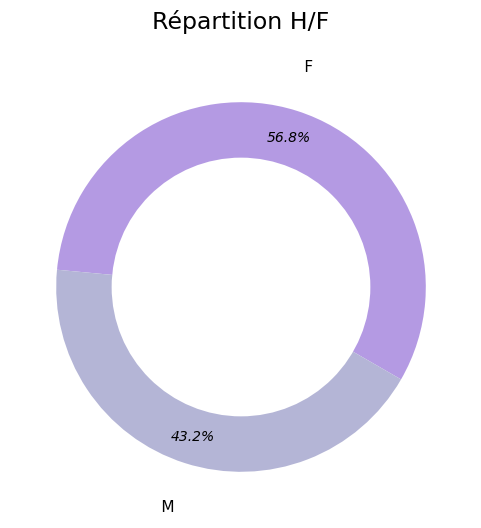

In [19]:
# Infos générales sur le dataset, exemple :
# répartition H/F (lecteurs/lectrices)

doughnut(data, 'gender', 'Répartition H/F')


In [20]:
# nb de lecteurs/lectrices
print(data['speaker'].nunique())

# nb de livres différents
print(data['book id'].nunique())


18
22


### 1.8 EDA texte


In [21]:
# describe nb mots

# test_data['nb_chars'] = test_data[1].apply(len)
test_data['nb_words'] = test_data[1].apply(lambda x: len(x.split()))

display(test_data[['nb_words']].describe())


,nb_words
count,1.0
mean,35.0
std,NaN
min,35.0
25%,35.0
50%,35.0
75%,35.0
max,35.0


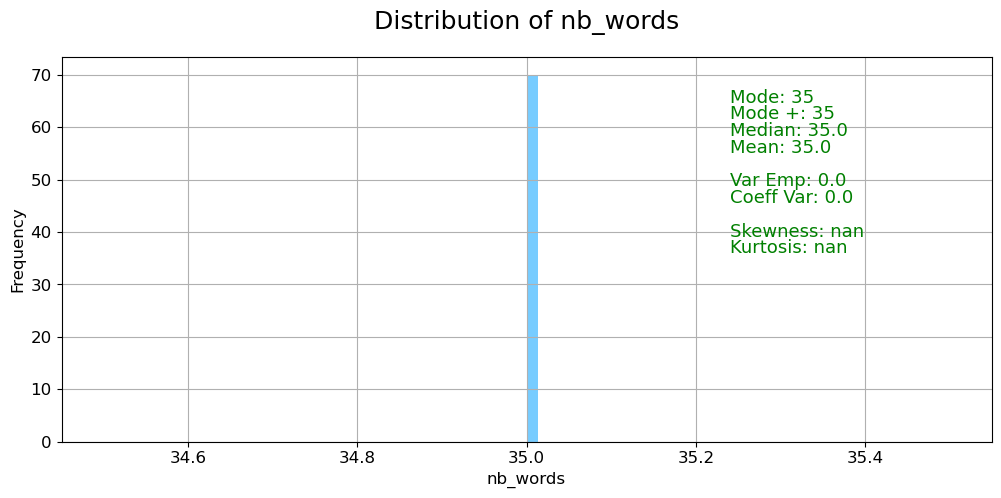

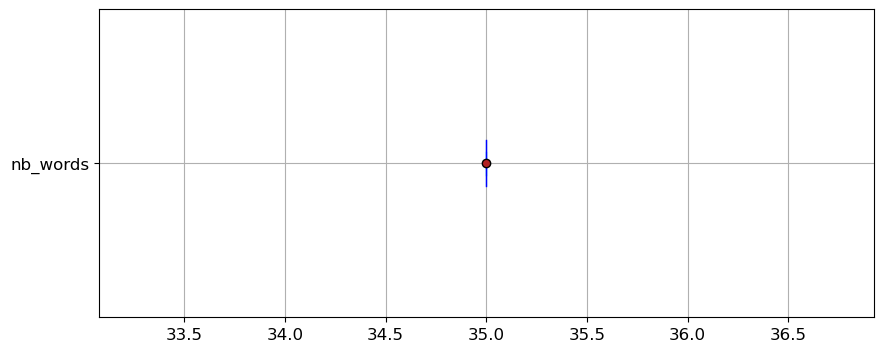

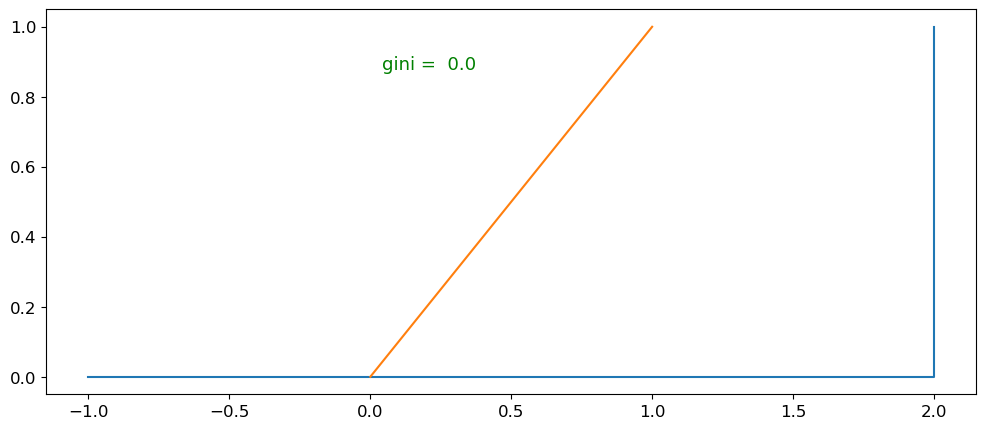

In [22]:
# Visualisation

graphs_analyse_uni(test_data, 'nb_words', bins=70, r=2)


In [23]:
# Observons qq transcripts

max_exemples = 10

for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, [1]].values[0][0], '\n')

# Pas de majuscules
# Pas de ponctuation, sauf apostrophes et tirets


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 



### 1.9 EDA audio


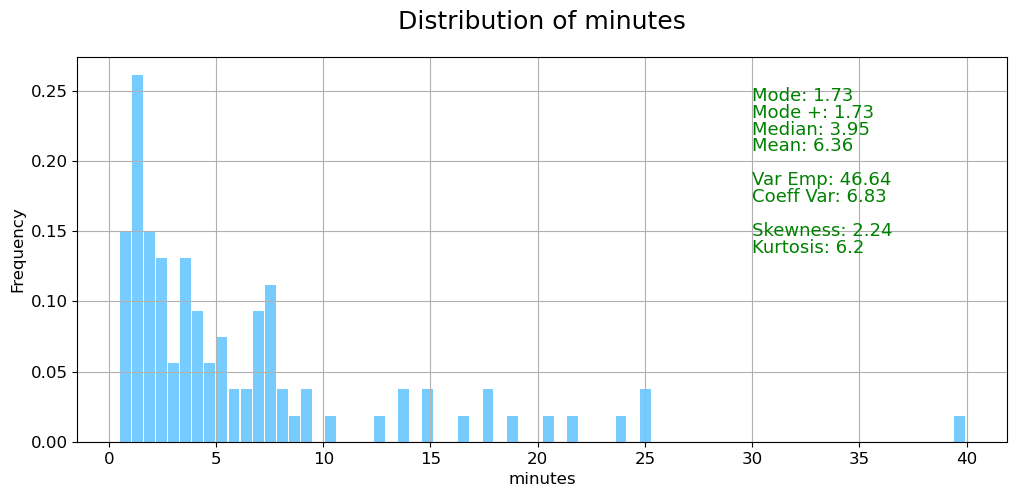

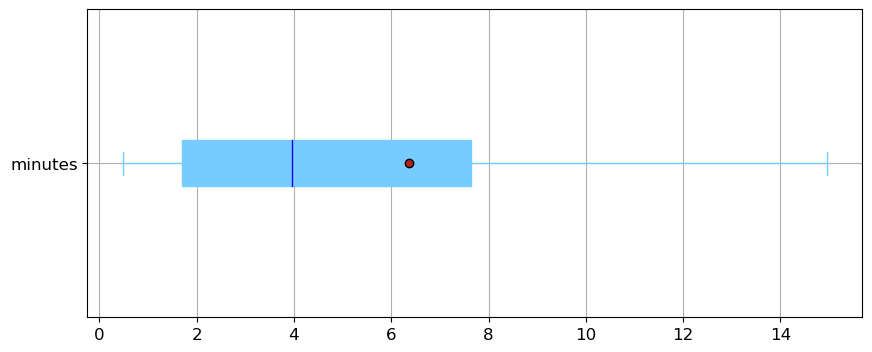

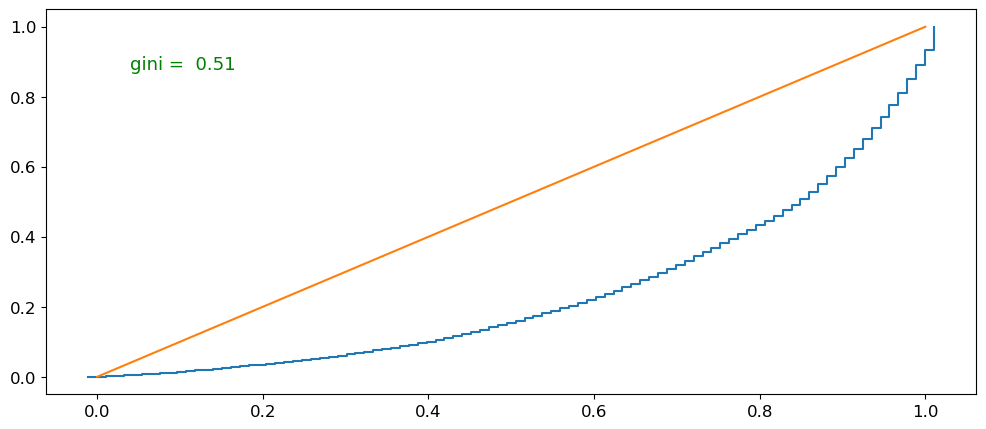

In [24]:
# Durée des enregistrements

graphs_analyse_uni(data, 'minutes', bins=70, r=2)

# Etonnament différent / nb mots.
# Ici : skewed à gauche
# nb mots : répartition gaussienne
# ??


In [25]:
# sample rate

def get_sample_rate(path):
    _, sample_rate = sf.read(path)

    return sample_rate

test_data['sample_rate'] = test_data['path'].apply(get_sample_rate)
test_data[['sample_rate']].describe()

# Tous encodés à 16 000 Hz
# (plutôt bas)


,sample_rate
count,1.0
mean,16000.0
std,NaN
min,16000.0
25%,16000.0
50%,16000.0
75%,16000.0
max,16000.0


In [26]:
# graphs_analyse_uni(test_data, 'sample_rate', bins=70, r=2)
# Pas besoin du coup

exemple_path = './data/mls_french_opus/test/audio/2085/1565/2085_1565_000000.opus'

# écouter
def play_opus(file_path):
    # Load the Opus file
    audio_data, sample_rate = sf.read(file_path) # renvoit le sample rate d'origine par defaut

    # Play the audio
    sd.play(audio_data, sample_rate)
    # sd.wait()

play_opus(exemple_path) # randomiser ?


# remarque : librosa modifie par défaut à 22 500 Hz (paramètre modifiable)

# origin
exemple_audio_sf, sample_rate_sf = sf.read(exemple_path)
print(sample_rate_sf) # (rappel)

# librosa
exemple_audio_librosa, sample_rate_librosa = librosa.load(exemple_path)
print(sample_rate_librosa)


16000


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


22050


## 2 Baseline, Transcription speech to text


In [27]:
# https://www.kaggle.com/code/stpeteishii/french-audio-wav2vec2-translation


Intro du notebook servant de baseline, présentation du modèle de transcription :

"facebook/wav2vec2-large-xlsr-53-french
The facebook/wav2vec2-large-xlsr-53-french model is a pre-trained speech recognition model that is specifically trained on French audio data. It is based on the Wav2Vec2 architecture, which is a transformer-based model that has been shown to be very effective for speech recognition tasks.

The facebook/wav2vec2-large-xlsr-53-french model is trained on a dataset of over 14,000 hours of French audio data. This data includes a variety of different speakers, recording conditions, and dialects. The model is also fine-tuned on a smaller dataset of manually transcribed French audio data.

Présentation du modèle utilisé pour la traduction :

facebook/nllb-200-distilled-600M
facebook/nllb-200-distilled-600M is a machine translation model from Facebook AI that can translate between 200 languages. It is a distilled version of the larger facebook/nllb-200-1.3B model, which was trained on a massive dataset of text and code. The distilled model is smaller and faster, but it still achieves state-of-the-art performance on translation tasks."


In [28]:
# Well, there is already a new state of the art.


### 2.1 Wav2Vec2


In [29]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/home/ubuntu/anaconda3/envs/myenv_p7/lib/python3.11/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53-french were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53-french and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should prob

In [30]:
def get_wav2vec_transcription(path):
    # Load the audio with the librosa library
    input_audio, _ = librosa.load(path, sr=16000)
    # data, sample_rate = librosa.load(file_path)
    # Tokenize the audio
    input_values = tokenizer(input_audio, return_tensors="pt", padding="longest").input_values
    # Feed it through Wav2Vec & choose the most probable tokens
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
    # Decode & add to our caption string
    transcription = tokenizer.batch_decode(predicted_ids)[0]

    return transcription


time_start = time.time()
test_data['baseline'] = test_data['path'].apply(get_wav2vec_transcription)
time_end = time.time()

time_predict_baseline = time_end - time_start
time_predict_baseline_moy = round(time_predict_baseline / test_data.shape[0], 2)

print(f'{time_predict_baseline_moy} s')
test_data.head()


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


5.73 s


,index,0,1,path,nb_words,sample_rate,baseline
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,35,16000,blanqui et milliare sortirent également le gou...


## 3 Nouvelle méthode


In [31]:
model_path = f'./data/whisper_{model_type}.pkl' # ??

model = whisper.load_model(f'{model_type}', download_root="./data/model_loaded") # small ou medium

# 461 M
# 1 G avec pickle ??


In [32]:
with open(model_path, 'wb') as f:
    # pickle.dump(model, f)
    pass

In [33]:
#Loading
audio_test = whisper.load_audio(exemple_path)
audio_test


array([-2.3345947e-02, -2.0599365e-02, -2.1789551e-02, ...,
        9.1552734e-05, -2.2277832e-03,  1.1901855e-03], dtype=float32)

In [34]:
audio = whisper.pad_or_trim(audio_test)

#Number of samples in our trimmed/padded audio
n_samples =  audio.shape[-1]
n_samples


480000

Avant


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

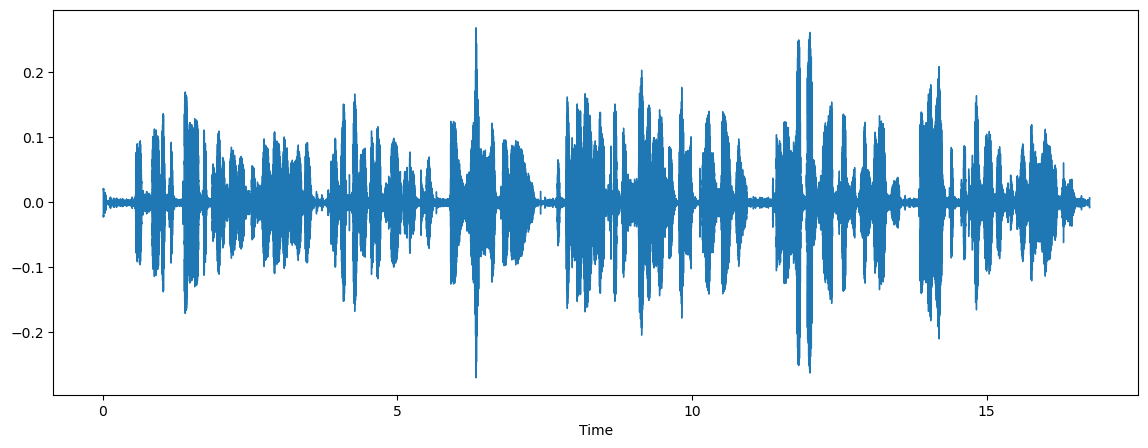

Après


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


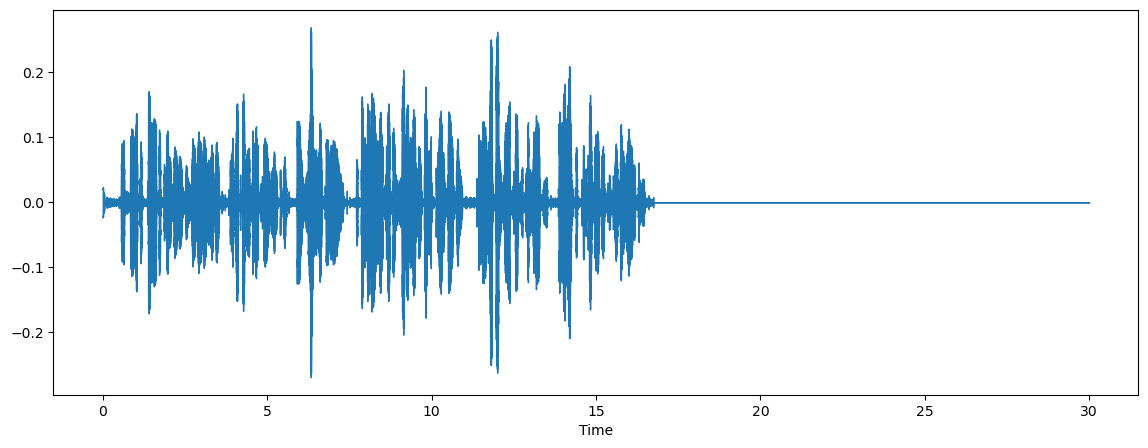

In [35]:
# original
print('Avant')
plt.figure(figsize=(14,5))
librosa.display.waveshow(exemple_audio_sf, sr=sample_rate_sf)
plt.show()

# après trimming
print('Après')
plt.figure(figsize=(14,5))
librosa.display.waveshow(audio,sr=sample_rate_sf)
plt.show()


In [36]:
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# (On reparlera de l'extraction de feature par mel encoding en conclusion)


In [37]:
if model_type != 'large':
    probs = model.detect_language(mel)
    print(len(list(probs[1])))
    probs[1]


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


99


In [39]:
if model_type != 'large':

    # Sort the dictionary based on predicted probabilities in descending order
    sorted_dict_probs = dict(sorted(probs[1].items(), key=lambda item: item[1], reverse=True))

    for langage, proba in list(sorted_dict_probs.items())[:1]:
        print(f'Langage détecté : {langage} ({proba}%)')

    transcription = model.transcribe(exemple_path, fp16 = False)['text']
    print(transcription)

# wow


Langage détecté : fr (0.986860454082489%)


### Prédictions sur testing set


In [40]:
def get_whisper_transcription(path):
    # syntaxe (encore) + courte !
    transcription = model.transcribe(path, fp16 = False)['text']

    return transcription


time_start = time.time()
test_data['new'] = test_data['path'].apply(get_whisper_transcription)
time_end = time.time()

time_predict_whisper = time_end - time_start
time_predict_whisper_moy = round(time_predict_whisper / test_data.shape[0], 2)

print(f'{time_predict_whisper_moy} s')
test_data.head()


# bcp + long, environ 6x
# (3 min pour whisper medium, contre 20s pour wav2vec2, sur 5 transcriptions

# Prend aussi + de ressources
# (presque 3 Go de + sur la RAM)

# Les performances sont-elles à la hauteur ?
# Déjà, on a la ponctuation !
# ... ce qui va par ailleurs compliquer l'évaluation...


13.36 s


,index,0,1,path,nb_words,sample_rate,baseline,new
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,35,16000,blanqui et milliare sortirent également le gou...,Blanqui et Miliaire sortirent également. Le g...


In [41]:
# Un peu dommage d'avoir à faire ça

def remove_punctuation(string):
    # remove_punctuation using regex + lower
    string = re.sub(r'[^\w\s\'\-]', '', string).lower().strip()

    return string


test_data['new_no_punct'] = test_data['new'].apply(remove_punctuation)

test_data.head()

# J'ai appris par la suite que Whisper possède sa propre méthode de normalisation
# (= ce qu'on a fait, lowering + ponctuation removal)


,index,0,1,path,nb_words,sample_rate,baseline,new,new_no_punct
0,1491,7400_2928_000019,blanqui et millière sortirent également le gou...,./data/mls_french_opus/test/audio/7400/2928/74...,35,16000,blanqui et milliare sortirent également le gou...,Blanqui et Miliaire sortirent également. Le g...,blanqui et miliaire sortirent également le gou...


## 4 Comparaison


In [42]:
for index in test_data.index[:max_exemples]:
    print(f'{index}', '\n')

    print('Texte d\'origine :')
    print(test_data.loc[test_data.index == index, [1]].values[0][0], '\n')

    print('Transcript wav2vec2 :')
    print(test_data.loc[test_data.index == index, ['baseline']].values[0][0], '\n')

    print('Transcript whisper :')
    print(test_data.loc[test_data.index == index, ['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    print(test_data.loc[test_data.index == index, ['new_no_punct']].values[0][0], '\n')

# seems ok


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript whisper :
 Blanqui et Miliaire sortirent également. Le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée. Le soir même du 31 octobre avait lieu à la Bourse une réunion des officiers de la Garde nationale 

Transcript whisper (no punct) :
blanqui et miliaire sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du 31 octobre avait lieu à la bourse une réunion des officiers de la garde nationale 



### 4.1 Metrique


In [43]:
# métrique :
# https://www.kaggle.com/code/kevinvaishnav/speechtotext

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    #print(ref_words, hyp_words)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


In [44]:
# exemples

print(_levenshtein_distance('abc', 'abcd')) # 1 transformation nécessaire (ajouter character d)
print(_levenshtein_distance('abc', 'ABC'), '\n') # Sensible à la casse !

print(wer('Ils sont partis', 'ils sont parti')) # taux = 2 erreurs / 3 mots (env 0.67)
print(wer('Ils sont partis', 'i sont pati')) # Compte une erreur max par mot

# Le wer ressemble aux règles utilisées pour noter une dictée à l'école.
# Il ne fait pas la différence entre une "petite erreur", par exemple un accent,
# et un mot complet mal transcrit.

# Du coup, quand +ieurs orthographes sont acceptées, c'est le transcript de référence qui compte.
# Par exemple si 2 orthographes sont possibles, le modèle a 1 chance sur 2 de renvoyer la "bonne".

# Cete métrique n'est donc pas parfaitement juste et objective, comme le sont un r2, une rmse, l'accuracy, etc...
# Elle nous permet cependant d'évaluer et de comparer nos modèles, à condition de l'utiliser
# sur un testing set suffisamment important pour corriger les aléas statistiques.


1
3 

0.6666666666666666
0.6666666666666666


### Eval


In [45]:
liste_wer_wav2vec = []
liste_wer_whisper = []

for index in test_data.index:
    print(f'{index}', '\n')

    df = test_data.loc[test_data.index == index, :]

    print('Texte d\'origine :')
    txt_origin = df[[1]].values[0][0]
    print(txt_origin, '\n')

    print('Transcript wav2vec2 :')
    transcript_baseline = df[['baseline']].values[0][0]
    print(transcript_baseline)

    wer_baseline = wer(txt_origin, transcript_baseline)
    print(wer_baseline, '\n')
    liste_wer_wav2vec.append(wer_baseline)

    print('Transcript whisper :')
    print(df[['new']].values[0][0], '\n')

    print('Transcript whisper (no punct) :')
    transcript_new_clean = df[['new_no_punct']].values[0][0]
    print(transcript_new_clean)

    wer_new = wer(txt_origin, transcript_new_clean)
    print(wer_new, '\n')
    liste_wer_whisper.append(wer_new)


# moyennes
mean_wer_baseline = np.mean(liste_wer_wav2vec)
mean_wer_new = np.mean(liste_wer_whisper)

print(mean_wer_baseline)
print(mean_wer_new)

# Serré !
# whisper medium > wav2vec2 > whisper small
# (proche, différence environ 1%)

# whisper base bcp + rapide, mais fait 2x + d'erreurs

# tracker tps pred moy

# whisper large
# bcp + long (1 min par pred en moyenne)
# mais les résultats sont impressionnants !


0 

Texte d'origine :
blanqui et millière sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du octobre avait lieu à la bourse une réunion des officiers de la garde nationale 

Transcript wav2vec2 :
blanqui et milliare sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole de néez le soir même du  octobre avait lieu à la bourse une réunion des officiers de la garde nationale
0.11428571428571428 

Transcript whisper :
 Blanqui et Miliaire sortirent également. Le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée. Le soir même du 31 octobre avait lieu à la Bourse une réunion des officiers de la Garde nationale 

Transcript whisper (no punct) :
blanqui et miliaire sortirent également le gouvernement n'osant pas d'abord montrer son mépris de la parole donnée le soir même du 31 octobre avait lieu à la bourse une réunion des officiers de la garde nationale
0.05714285714285714 

0.11

### save results


In [46]:
# baseline
path_results_wav2vec = f'./pickle/results_baseline.pkl'
results_baseline = {
    'model': f'wav2vec2',
    'size test set': f'{size_test}',
    'WER': f'{mean_wer_baseline:.3f}',
    'time_predict (s)': f'{time_predict_baseline_moy}'
}

with open(path_results_wav2vec, 'wb') as f:
        pickle.dump(results_baseline, f)

# new
path_results_whisper = f'./pickle/results_whisper_{model_type}.pkl'
results_whisper = {
    'model': f'whisper_{model_type}',
    'size test set': f'{size_test}',
    'WER': f'{mean_wer_new:.3f}',
    'time_predict (s)': f'{time_predict_whisper_moy}'
}

with open(path_results_whisper, 'wb') as f:
        pickle.dump(results_whisper, f)


In [47]:
# display results

# f'./pickle/pretrained/{nb_classes}_classes/{base_model_name}_{nb_layers_trainable}_lay_{sample_ratio*100}_pc_params.pkl'

def check_results(path=f'./pickle'):
    """"""

    data_path = glob(path+f'/*results*.pkl')
    list_files = [file for file in data_path]
    print(len(list_files))

    dfs = []

    for file in list_files:
         with open(file, 'rb') as f:
            params_dict = pickle.load(f)
            df = pd.DataFrame.from_dict(params_dict, orient='index').T
            dfs.append(df)

    if dfs:
        result_df = pd.concat(dfs, ignore_index=True)
        return result_df
    else:
        print("No pickled dictionaries found.")
        return None


result_df = check_results()

if result_df is not None:
    # Sort the DataFrame by accuracy in descending order (higher is better)
    result_df.sort_values(by='WER', ascending=False, inplace=True)

    display(result_df.head(10))  # Display the concatenated DataFrame


2


,model,size test set,WER,time_predict
0,wav2vec2,1,0.11428571428571428,5.73
1,whisper_small,1,0.05714285714285714,13.36


## Bonus : traduction


In [48]:
translation = model.transcribe(exemple_path, language = 'en', fp16 = False)['text']
translation

# marrant
# pas parfait mais excellent. a corrigé "verris"


' My brother was so absorbed in his chemical visions that he represented the action with his foot, as if it was real to him, and by then he hit him so hard his panic full of glass that he threw it from the top of his street shop so that all the glass was broken in a thousand pieces.'

In [49]:
translation = model.transcribe(exemple_path, language = 'ja', fp16 = False)['text']
translation

# ??


'彼に関してはやっと悪いひねと言っていました。彼はそれがこの耳で私は目当けしています!'

## done


In [50]:
# eval


## Conclusion : synthèse


In [51]:
# Les modèles comme word2vec, construits


## Pistes d'amélioration
